In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [4]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2019-09-20 09:36:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.166.128, 2a00:1450:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.166.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2019-09-20 09:36:54 (80.7 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [5]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


W0920 09:36:56.852933 140653217904512 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/keras/initializers.py:119: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0920 09:36:56.883177 140653217904512 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0920 09:36:56.891062 140653217904512 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:97: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be r

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [6]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

W0920 09:36:58.046986 140653217904512 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
15462/15462 [==============================] - 43s 3ms/sample - loss: 6.8955 - acc: 0.0196
Epoch 2/100
15462/15462 [==============================] - 42s 3ms/sample - loss: 6.5007 - acc: 0.0233
Epoch 3/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 6.3712 - acc: 0.0266
Epoch 4/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 6.2576 - acc: 0.0305
Epoch 5/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 6.1727 - acc: 0.0362
Epoch 6/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 6.0936 - acc: 0.0376
Epoch 7/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 6.0107 - acc: 0.0436
Epoch 8/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 5.9217 - acc: 0.0473
Epoch 9/100
15462/15462 [==============================] - 41s 3ms/sample - loss: 5.8256 - acc: 0.0529
Epoch 10/100
15462/15462 [==============================] - 41s 3ms/sampl

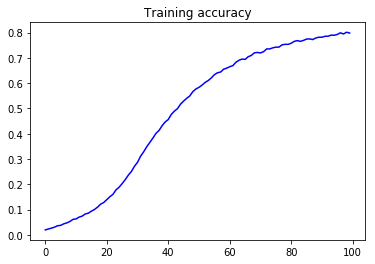

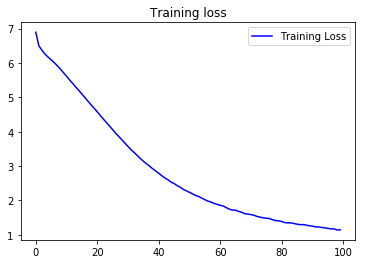

In [7]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [8]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope are you with your rhyme rhyme part to tell pain ride go wide near survey rare exceeds razed gone or forth each ' lies go delight skill past way dwells quite fitted fitted twain hate men past days twain twain go rhyme delight tongue delight skill report light hits fitted sway'st quite fitted back live good rage doth date light quite quite had did give ill twain write 'tis me life away things fire fire past youth so best live they forsworn thee die mine eyes grew ill decrease decrease in their moan me in hate night new new days
